# Training Neural Networks
In this exercise, you will train a neural network using PyTorch. You will be provided some starter code and will fill in the blanks. 

This will walk through the entire process, from loading datasets to creating transforms, all the way through to creating the network code and training it to classify the CIFAR-10 dataset.

In [1]:
# DO NOT EDIT THIS CELL
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

/Users/omarnagy/Downloads/migration/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading and Preprocessing Data
In this section, we will load and preprocess our data using any relevant methods from `transforms` and `datasets`.
Then, we will create `DataLoader`s for our train and test sets.

If you have trouble, feel free to consult the documentation for [transforms](https://pytorch.org/vision/0.12/transforms.html) and [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10)

In [19]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

# Establish our transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
# Load train and test datasets
training_data = datasets.CIFAR10('cifar-10-batches-py', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('cifar-10-batches-py', train=False, download=True, transform=transform)

# Create the training and test dataloaders
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

tensor([1.], device='mps:0')
Files already downloaded and verified
Files already downloaded and verified


## Defining our Neural Network
Once our data is loaded, we want to define our model. 
For this example, we want to use a fully-connected model, which means we will need to use the `flatten` method to take our 32 x 32 x 3 tensor and flatten it into a single input. 

We want to have at least 2 hidden layers. 
The input size of the first layer will need to account for the flattening and will be 32 * 32 * 3.
Feel free to experiment here, and if you need additional help, consult the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html)

In [35]:
# Define the class for your neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # set the activation function as ReLU
        self.activation = F.relu
        self.layer1 = nn.Linear(3072, 240)
        self.layer2 = nn.Linear(240, 120)
        self.layer3 = nn.Linear(120, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

# Instantiate the model
net = Net()
net.to(mps_device)

Net(
  (layer1): Linear(in_features=3072, out_features=240, bias=True)
  (layer2): Linear(in_features=240, out_features=120, bias=True)
  (layer3): Linear(in_features=120, out_features=10, bias=True)
)

## Optimizer and Loss function
Before we get into our training loop, we need to choose an optimizer and loss function for our network. 

In [36]:
# Choose an optimizer
#optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001, amsgrad=True)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
# Choose the multi-class criterion function
criterion = nn.CrossEntropyLoss()

## Creating the Training Loop
With our network, optimizer, and loss function, we can now begin the training step! 
Using the test set to validate our accuracy, we can see when our network has given us the best fit.

In [37]:
num_epochs = 5

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to the mac mps_device GPU if available.
        inputs, labels = inputs.to(mps_device), labels.to(mps_device)
        
        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of your model and compute your loss
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Compute the loss gradient using the backward method and have the optimizer take a step
        loss.backward()
        
        
        optimizer.step()
        
        # Compute the accuracy and print the accuracy and loss
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).float().mean().item()
        train_loss += loss.item()
        
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    # The validation step is done for you.
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(mps_device), labels.to(mps_device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)        
        val_correct += (preds == labels).float().mean().item()
        val_loss += loss.item()
        
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 0.27% training loss: 2.05607
Epoch 1 validation accuracy: 0.34% validation loss: 1.85056
Epoch 2 training accuracy: 0.37% training loss: 1.76734
Epoch 2 validation accuracy: 0.40% validation loss: 1.69041
Epoch 3 training accuracy: 0.42% training loss: 1.64968
Epoch 3 validation accuracy: 0.43% validation loss: 1.60611
Epoch 4 training accuracy: 0.45% training loss: 1.57679
Epoch 4 validation accuracy: 0.46% validation loss: 1.55769
Epoch 5 training accuracy: 0.47% training loss: 1.52173
Epoch 5 validation accuracy: 0.47% validation loss: 1.51264


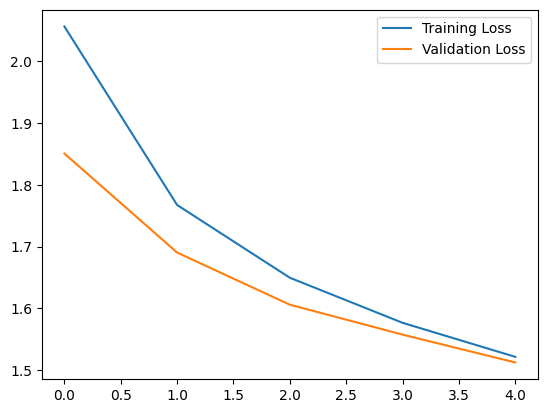

In [38]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()